<a href="https://colab.research.google.com/github/IlyaGenShubin/UrFO/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Подключаем необходимые библиотеки**

In [ ]:
import tensorflow as tf                                                         # Импорт tensorflow
import numpy as np                                                              # Библиотека работы с массивами
import pandas as pd                                                             # Для работы с таблицами
import os                                                                       # Модули для работы с файлами
import gc                                                                       # Модуль для сборка мусора
from keras.preprocessing import image                                           # Метод обработки изображений библиотеки Keras
from keras.callbacks import EarlyStopping, ModelCheckpoint                      # Импортируем колбэки: Ранняя остановка обучения и Сохранение модели
from tensorflow.keras.models import load_model                                  # Загрузка модели
import shutil                                                                   # Модуль для обработки файлов, групп файлов, и папок
import time                                                                     # Модуль для работы со временем
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Подключение диска
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Подготовка датасета и обучение модели**


Found 2090 files belonging to 3 classes.
Using 1672 files for training.
Found 2090 files belonging to 3 classes.
Using 418 files for validation.
Epoch 1/50
209/209 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.7590
Epoch 1: val_loss improved from inf to 0.46768, saving model to /content/drive/MyDrive/UrFO/efficientnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/209 [==============================] - 358s 990ms/step - loss: 0.6593 - accuracy: 0.7590 - val_loss: 0.4677 - val_accuracy: 0.8373
Epoch 2/50
209/209 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8935
Epoch 2: val_loss improved from 0.46768 to 0.32972, saving model to /content/drive/MyDrive/UrFO/efficientnet.h5
209/209 [==============================] - 199s 953ms/step - loss: 0.3216 - accuracy: 0.8935 - val_loss: 0.3297 - val_accuracy: 0.8947
Epoch 3/50
209/209 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9420
Epoch 3: val_loss improved from 0.32972 to 0.29283, saving model to /content/drive/MyDrive/UrFO/efficientnet.h5
209/209 [==============================] - 205s 980ms/step - loss: 0.1887 - accuracy: 0.9420 - val_loss: 0.2928 - val_accuracy: 0.8947
Epoch 4/50
209/209 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9605
Epoch 4: val_loss improved from 0.29283 to 0.28061, saving model to /content/drive/

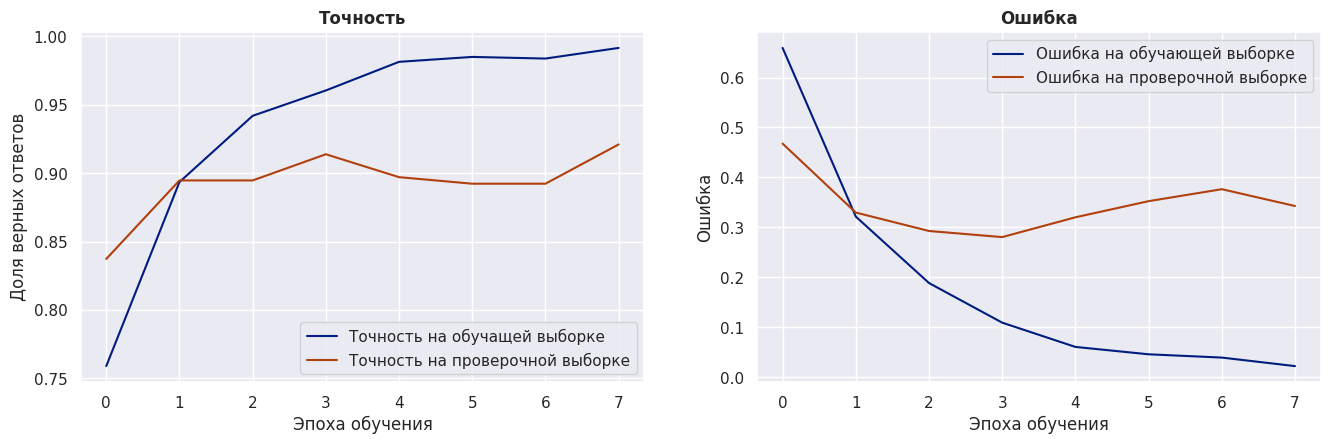

In [ ]:
data_dir = '/content/drive/MyDrive/UrFO/train'                                  # Присваиваем путь к базе в переменную data_dir
batch_size = 8                                                                  # Определяем batch size
image_size = (299, 299)                                                         # Определяем размер изображений

train_ds = tf.keras.preprocessing.image_dataset_from_directory(                 # Формируем обучающий датасет:
  data_dir,                                                                     # путь к изображениям
  validation_split = 0.2,                                                       # устанавливаем разделение на обучающую и проверочную выборки (20%)
  subset = "training",                                                          # помечаем, что выборка обучающая (80%)
  seed = 123,                                                                   # дополнительное случайное начальное число для перетасовки и преобразований
  image_size = image_size,                                                      # размер изображений, который был задан ранее
  batch_size = batch_size)                                                      # размер батча, который был задан ранее

val_ds = tf.keras.preprocessing.image_dataset_from_directory(                   # Формируем проверочный датасет:
  data_dir,                                                                     # путь к изображениям
  validation_split = 0.2,                                                       # устанавливаем разделение на обучающую и проверочную выборки (20%)
  subset = "validation",                                                        # помечаем, что выборка проверочная (20%)
  seed = 123,                                                                   # дополнительное случайное начальное число для перетасовки и преобразований
  image_size = image_size,                                                      # размер изображений, который был задан ранее
  batch_size = batch_size)                                                      # размер батча, который был задан ранее

class_names = train_ds.class_names                                              # Определяем имена классов

AUTOTUNE = tf.data.AUTOTUNE                                                     # Предварительная подгрузка датасета для ускорения обучения и стабилизации
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)                      # Предварительная обучающая выборка
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)                          # Предварительная тестовая выборка

data_augmentation = tf.keras.Sequential([                                       # Аугментация данных:
  tf.keras.layers.experimental.preprocessing.RandomZoom((-0.05,0.05)),          # изменение размера
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),              # поворот
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)])             # контраст

gc.collect()                                                                    # Сборка мусора для освобождения памяти
preprocess_input = tf.keras.applications.efficientnet.preprocess_input          # Нормализация данных на вход в соответствии требованиям модели
image_shape = image_size + (3,)                                                 # Определяем входную размерность в соответствии требованиям модели
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()                 # Задаем слой GlobalAveragePooling2D
prediction_layer = tf.keras.layers.Dense(len(class_names))                      # Задаем выходной слой на нужное нам количество классов

base_model = tf.keras.applications.efficientnet.EfficientNetB7(                 # Создаем базовую модель EfficientNet:
    input_shape=image_shape,                                                    # устанавливаем размер входных изображений
    include_top=False,                                                          # не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
    weights='imagenet')                                                         # используем веса уже предобученной модели на базе Imagenet

inputs = tf.keras.Input(shape=(image_shape))                                    # Задаём входную размерность
x = data_augmentation(inputs)                                                   # Аугментация в виде слоя для модели
x = preprocess_input(x)                                                         # Нормализация данных на вход
x = base_model(x, training=False)                                               # Базовая модель EfficientNet
x = global_average_layer(x)                                                     # Cлой GlobalAveragePooling2D
x = tf.keras.layers.Dropout(0.1)(x)                                             # Слой регуляризации Dropout (отключаем 10% нейронов в слое)
outputs = prediction_layer(x)                                                   # Выходной слой на три класса
model = tf.keras.Model(inputs, outputs)                                         # Собирем полную модель

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),             # Компилируем модель: Оптимизатор Adam c заданным шагом обучения
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # ошибка SparseCategoricalCrossentropy
              metrics=['accuracy'])                                                  # метрика Accuracy

early_stop = EarlyStopping(                                                     # Установим раннюю остановку обучения:
                        monitor='val_loss',                                     # отслеживание ошибки на проверочной выборке
                        min_delta=0.01,                                         # минимальное изменение ошибки, которое можно квалифицировать как улучшение
                        patience=4,                                             # количество периодов без улучшения, после которых обучение будет остановлено
                        verbose=1,                                              # визуализация процесса
                        baseline=None,                                          # обучение остановится, если модель не покажет улучшения по сравнению с базовым уровнем
                        restore_best_weights=True)                              # восстановим веса модели из эпохи с лучшим значением отслеживаемой величины

model_сheckpoint = ModelCheckpoint(                                                          # Определим сохранение модели:
                                   filepath='/content/drive/MyDrive/UrFO/efficientnet.h5',   # укажем место для сохранения
                                   monitor='val_loss',                                       # для контроля общих потерь модели на проверочной выборке
                                   verbose=1,                                                # визуализация процесса
                                   save_best_only=True,                                      # сохраняется только тогда, когда модель считается «лучшей»
                                   mode='auto',                                              # авто режим
                                   baseline=None)

callbacks = [early_stop, model_сheckpoint]                                      # Сформируем созданные колбэки

history = model.fit(                                                            # Запускаем обучение:
                   train_ds,                                                    # обучающая выборка
                   epochs=50,                                                   # количество эпох обучения
                   validation_data=val_ds,                                      # проверочная выборка
                   callbacks=callbacks)                                         # колбэки

sns.set(style='darkgrid', palette='dark')                                            # Задаём стиль полотна графика
plt.figure(figsize=(16, 10))                                                         # Устанавливаем размер
plt.subplot(2, 2, 1)                                                                 # Определяем положение 1го графика
plt.title('Точность', fontweight='bold')                                             # Название графика
plt.plot(history.history['accuracy'], label='Точность на обучащей выборке')          # Данные точности на обучающей выборке
plt.plot(history.history['val_accuracy'], label='Точность на проверочной выборке')   # Данные точности на проверочной выборке
plt.xlabel('Эпоха обучения')                                                         # Подпись оси Х
plt.ylabel('Доля верных ответов')                                                    # Подпись оси У
plt.legend()                                                                         # Отображение легенды
plt.subplot(2, 2, 2)                                                                 # Определяем положение 2го графика
plt.title('Ошибка', fontweight='bold')                                               # Название графика
plt.plot(history.history['loss'], label='Ошибка на обучающей выборке')               # Данные ошибки на обучающей выборке
plt.plot(history.history['val_loss'], label='Ошибка на проверочной выборке')         # Данные ошибки на проверочной выборке
plt.xlabel('Эпоха обучения')                                                         # Подпись оси Х
plt.ylabel('Ошибка')                                                                 # Подпись оси У
plt.legend()                                                                         # Отображение легенды
plt.show()                                                                           # Выведем график обучения

**Распознавание фотографий**

In [ ]:
model = load_model('/content/drive/MyDrive/UrFO/efficientnet.h5')               # Загрузка модели
preprocess_input = tf.keras.applications.efficientnet.preprocess_input          # Нормализация данных на вход в соответствии требованиям модели
class_names = ['0', '1', '2']                                                   # Определяем классы
image_size = (299, 299)                                                         # Определяем размер изображений
model.summary()                                                                 # Выводим сводку по загруженной модели

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 10, 10, 2560)      64097687  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 3)                 7683  

1/1 [==============================] - 1s 952ms/step
Категория изображения -  0


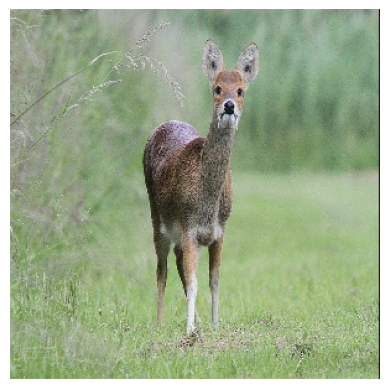

In [ ]:
def predict_image_category(path, model, preprocess_input, image_size):
    # Загружаем изображение и устанавливаем необходимый размер
    img = image.load_img(path, target_size=image_size)

    # Отключаем оси
    plt.axis('off')

    # Выводим фотографию на экран
    plt.imshow(img)

    # Формируем массив данных
    x = image.img_to_array(img)

    # Добавляем одно измерение в начало массива
    x = np.expand_dims(x, axis=0)

    # Нормализация данных на вход в соответствии требованиям модели
    x = preprocess_input(x)

    # Предиктим результат
    pred = model.predict(x)

    # Находим максимальное значение
    cls_image = np.argmax(pred)

    # Выводим на экран Категорию изображения
    print('Категория изображения - ', cls_image)

# Пример вызова функции
path = '/content/drive/MyDrive/UrFO/test/0u537087a1-3839f6d6-f6de7700.jpg'
predict_image_category(path, model, preprocess_input, image_size)


1/1 [==============================] - 1s 821ms/step
Категория изображения -  1


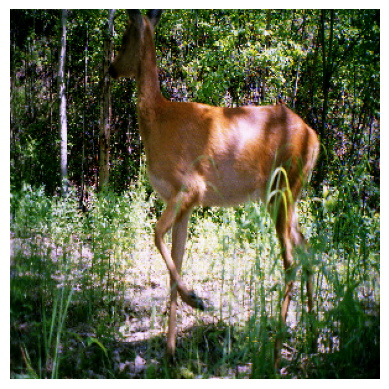

In [ ]:
predict_image_category('/content/drive/MyDrive/UrFO/test/tr66_roeDeer_14.06.2008_002.jpg', model, preprocess_input, image_size)                            # Выводим на экран Категорию изображения

1/1 [==============================] - 1s 1s/step
Категория изображения -  2


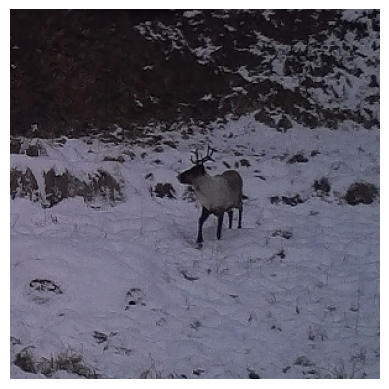

In [ ]:
predict_image_category('/content/drive/MyDrive/UrFO/test/Северный олень (64).JPG', model, preprocess_input, image_size)                            # Выводим на экран Категорию изображения

**Screencast**

In [ ]:
CurrentTime = time.time()                                                       # Засекаем время для измерения времени обработки
path = '/content/drive/MyDrive/UrFO/test/'                                      # Путь к папке с изображениями
test_list = os.listdir(path)                                                    # Формируем список с именами распознаваемых файлов
destination_0 = '/content/drive/MyDrive/UrFO/Moschiferus'                       # Путь к папке с фотографиями без баков
destination_1 = '/content/drive/MyDrive/UrFO/Cervidae'                          # Путь к папке с соответствующими фотографиями
destination_2 = '/content/drive/MyDrive/UrFO/Capreolus '                        # Путь к папке с фотографиями плохого качества
for file in test_list:                                                          # Проходимся циклом по списку
  img = image.load_img(path + (file), target_size=image_size)                   # Загружаем изображение
  x = image.img_to_array(img)                                                   # Переводим её в массив данных
  x = np.expand_dims(x, axis=0)                                                 # Добавляем одно измерение в начало массива
  x = preprocess_input(x)                                                       # Нормализация данных на вход в соответствии требованиям модели
  pred = model.predict(x)                                                       # Предиктим результат
  cls_image = np.argmax(model.predict(x))                                       # Находим максимальное значение
  if cls_image == 0:                                                            # Если распознан класс 0, то
    shutil.move(path + (file), destination_0)                                   # переносим файл в папку Кабарга
  if cls_image == 1:                                                            # Если распознан класс 1, то
    shutil.move(path + (file), destination_1)                                   # переносим файл в папку Косуля
  if cls_image == 2:                                                            # Если распознан класс 2, то
    shutil.move(path + (file), destination_2)                                   # переносим файл в папку Олень
print('Фотографии в количестве', len(test_list), 'шт. рассортированы!')         # Выводим информацию об успешной обработке, кол-ве и времени
print('Время обработки: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))

1/1 [==============================] - 1s 1s/step
Фотографии в количестве 3 шт. рассортированы!
Время обработки: 8 секунд (0.14 минут)


**Файл для отправки решения**

In [ ]:
Class = []                                                                      # Создаём пустой список
path = '/content/drive/MyDrive/UrFO/test/'                                      # Путь к папке с изображениями
test_list = os.listdir(path)                                                    # Формируем список с именами распознаваемых файлов
for file in test_list:                                                          # Проходимся циклом по списку
  img = image.load_img(path + file, target_size=image_size)                     # Загружаем изображение
  x = image.img_to_array(img)                                                   # Переводим её в массив данных
  x = np.expand_dims(x, axis=0)                                                 # Добавляем одно измерение в начало массива
  x = preprocess_input(x)                                                       # Нормализация данных на вход в соответствии требованиям модели
  pred = model.predict(x)                                                       # Предиктим результат
  cls_image = np.argmax(model.predict(x))                                       # Находим максимальное значение
  Class.append(class_names[cls_image])                                          # Результат заносим в пустой список
data = {'img_name': test_list, 'class': Class}                                  # Совмещаем списки имён файлов и результат предсказания
df = pd.DataFrame(data)                                                         # Создаём DataFrame
df.to_csv('/content/drive/MyDrive/UrFO/submission.csv', sep=',', index=False)   # Сохраняем файл
print('Файл сохранён')                                                          # Вывод информации об успешном сохранении файла